In [78]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

class Stock():
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.date = data.index
        self.prices = data['Close']
        self.models = None
        self.func = self.geometric_brownian_motion
    
    def close(self):
        self.prices = self.data['Close']
        return self
    def open(self):
        self.prices = self.data['Open']
        return self
    def high(self):
        self.prices = self.data['High']
        return self
    def low(self):
        self.prices = self.data['Low']
        return self
    
    def log(self):
        return  self.prices.apply(np.log)
    def diff(self):
        return self.prices.apply(np.diff)
    def log_diff(self):
        return self.prices.apply(np.log).apply(np.diff)
    def print_prices(self):
        return self.prices
            
    def average(self):
        return self.prices.mean().item()
    def standard_deviation(self):
        return self.prices.std().item()
    def drift(self):
        return self.diff().dropna().mean().item()
    def volatility(self):
        return self.diff().dropna().std().item()
    
    def average_log(self):
        return self.log().mean()
    def standard_deviation_log(self):
        return self.log().std()
    def drift_log(self):
        return self.log_diff().mean()
    def volatility_log(self):
        return self.log_diff().std()
    
    def simulation(self, n):
        models = []
        for i in range(n):
            S = self.func()
            models.append(S)
        self.models = models
        return self.models
    
    def plot_models(self):
        plt.figure(figsize=(12, 6))
        for model in self.models:
            plt.plot(self.date, model)
        plt.ylabel('price ($)')
        plt.grid(True)
        plt.show
        return
    
    def geometric_brownian_motion(self):
        t = np.arange(len(self.date))
        W = np.random.standard_normal(len(self.date))
        W = np.cumsum(W)
        drift_array = np.full(len(t), self.drift_log() - 0.5 * self.volatility_log()**2)
        diffusion_array = np.full(len(W), self.volatility_log())
        X = drift_array * t + diffusion_array * W
        S0_array = np.full(len(X), self.prices.iloc[0])
        S =  S0_array* np.exp(X)
        self.func = self.geometric_brownian_motion
        return S
    
    def candlestick(self, day=200, moving_average=[5, 10, 20 ,50, 75, 100]):
        # prepare data
        candlestick_data = self.data.copy()
        candlestick_data = candlestick_data.reset_index()
        candlestick_data['Date'] = candlestick_data['Date'].map(mdates.date2num)
        candlestick_data = candlestick_data[-day:]

        fig, ax = plt.subplots(figsize=(12, 6))
        # illustrate a candlestick
        candlestick_ohlc(ax, candlestick_data[['Date', 'Open', 'High', 'Low', 'Close']].values, 
                        width=1, colorup='g', colordown='r')
        # add a moving average
        for ma in moving_average:
            candlestick_data[f'MA{ma}'] = candlestick_data['Close'].rolling(ma).mean()
            ax.plot(candlestick_data['Date'], candlestick_data[f'MA{ma}'], label=f'{ma} day moving average')

        ax.xaxis_date()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.title(f'candlestick')
        plt.xlabel('Date')
        plt.ylabel('price (USD)')
        plt.legend()
        plt.grid(True)
        plt.show()


class Option():
    def __init__(self, stock: Stock, strike_price: float, maturity: float, rate: float, S0: float=None):
        self.stock = stock
        self.K = strike_price
        self.T = maturity
        self.r = rate
        if S0 == None:
            self.S0 = stock.prices.iloc[-1]
        else:
            self.S0 = S0
        self.type = None
        self.style = None
    
    def call(self):
        self.type = 'call'
        return self
    
    def put(self):
        self.type = 'put'
        return self
    
    def European(self):
        return European(self)
    
    # Function to plot 2D graph with selectable x-axis
    def plot_curve(self, S_range: float=None, num_points=100):
        # X-axis: Stock price, Y-axis: Option price
        if S_range == None:
            S = np.linspace(0,self.K*2, num_points)
        else:
            S = np.linspace(0, S_range, num_points)
        initial_S0 = self.S0
        V = []
        for s in S:
            self.S0 = s
            if self.type == 'call':
                V.append(self.call().European().closed_form())
            if self.type == 'put':
                V.append(self.put().European().closed_form())
        V = np.array(V)
        print(len(V))
        print(len(S))
        self.S0 = initial_S0

        # Plotting
        plt.figure(figsize=(8, 6))
        plt.plot(S, V, label=f'stike price={self.K} \n maturity={self.T} \n S0={self.S0.item()} \n rate={self.r}\n volatility={self.stock.volatility()}')
        plt.xlabel('Stock Price (S)')
        plt.ylabel(f'{self.type.capitalize()} Option Price (V)')
        plt.title(f'Black-Scholes {self.type.capitalize()} Option Price')
        plt.grid(True)
        plt.legend()
        plt.show()
        plt.close()
        return 

class Call(Option):
    def __init__(self, stock: Stock, strike_price: float, maturity: float, rate:float, S0: float=None):
        super().__init__(stock, strike_price, maturity, rate, S0)
        self.type = 'call'

    def European(self):
        return European(self)
    
class Put(Option):
    def __init__(self, stock: Stock, strike_price: float, maturity: float, rate: float, S0: float=None):
        super().__init__(stock, strike_price, maturity, rate, S0)
        self.type = 'put'

    def European(self):
        return European(self)
    
class European():
    def __init__(self, option):
        self.option = option
        self.stock = option.stock
        self.K = option.K
        self.T = option.T
        self.r = option.r
        self.mu = option.stock.drift()
        self.sigma = option.stock.volatility()
        self.type = option.type
        self.S0 = option.S0
        # print(self.S0)

    def __call__(self):
        return self.closed_form()

    def closed_form(self):
        d1 = (np.log(self.S0) - np.log(self.K) + (self.mu + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        if self.type == 'call':
            price = self.S0 * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
        if self.type == 'put':
            price = - self.S0 * norm.cdf(-d1) + self.K * np.exp(-self.r * self.T) * norm.cdf(-d2)
        if self.type != 'call' and self.type != 'put':
            print('error')
        return price.item()

    
        

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_4195/2499493860.py:201: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S0) - np.log(self.K) + (self.mu + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))


100
100


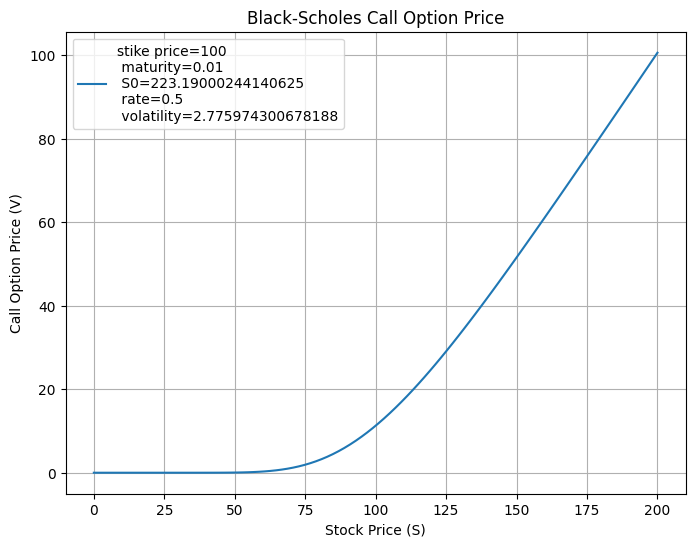

In [83]:
if __name__ == "__main__":
    stock_data = yf.download('AAPL', start='2020-03-01') #, end='2023-12-31')
    
    # yfinance_stockクラスのインスタンス
    stock = Stock(stock_data)
    # stock.close()
    # print(stock.print_prices())
    # print(stock.drift())
    # stock.candlestick()
    # print('log', stock.log())
    # print('diff', stock.diff())
    # print('log diff', stock.log_diff())
    # print(stock.geometric_brownian_motion())
    # stock.simulation(20)
    # stock.plot_models()
    option = Option(stock, 100, 0.01, 0.5)
    option.call().plot_curve()
    # print('CE', option.European()())\
    

[[1.67796680e-264 3.17310396e-235 1.03818367e-208 ... 4.59683548e+001
  4.80091712e+001 5.00499875e+001]
 [2.58592447e-089 1.35251260e-079 8.63510121e-071 ... 4.60692738e+001
  4.81100901e+001 5.01509064e+001]
 [2.27054526e-054 1.56510001e-048 3.06363967e-043 ... 4.61700908e+001
  4.82109071e+001 5.02517235e+001]
 ...
 [1.75982985e-003 3.82311820e-003 7.78576262e-003 ... 5.07242441e+001
  5.27435565e+001 5.47665654e+001]
 [2.06089799e-003 4.41191727e-003 8.86582376e-003 ... 5.08278372e+001
  5.28461771e+001 5.48683243e+001]
 [2.39941755e-003 5.06472011e-003 1.00481614e-002 ... 5.09314942e+001
  5.29488594e+001 5.49701401e+001]]


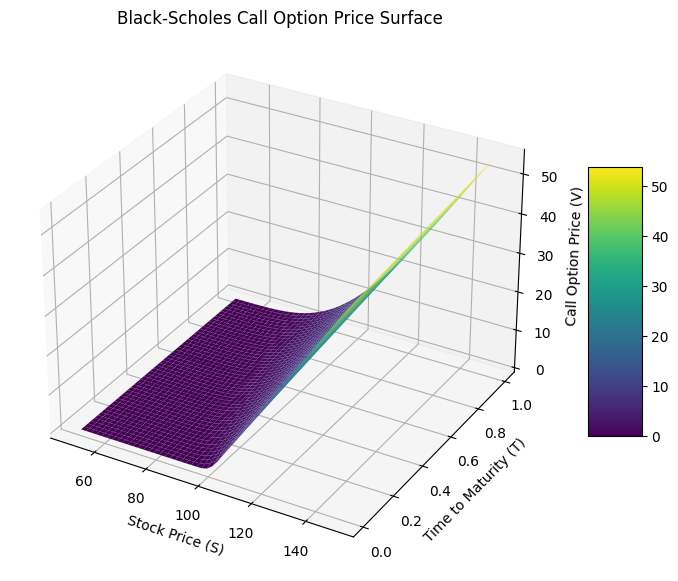

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

# Black-Scholes formula for a European Call Option
def black_scholes_call(S, K, T, r, sigma):
    """
    S: Stock price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free interest rate
    sigma: Volatility of the underlying asset
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Parameters
K = 100        # Strike price
r = 0.05       # Risk-free rate (5%)
sigma = 0.2    # Volatility (20%)

# Create a grid of stock prices and times
S = np.linspace(50, 150, 50)  # Stock price range from 50 to 150
T = np.linspace(0.01, 1, 50)  # Time to maturity from 0.01 to 1 year
S, T = np.meshgrid(S, T)      # Create a 2D grid

# Calculate option prices over the grid
V = black_scholes_call(S, K, T, r, sigma)
print(V)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S, T, V, cmap='viridis')

# Labels
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Call Option Price (V)')
ax.set_title('Black-Scholes Call Option Price Surface')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show plot
plt.show()


[2.22658851e-06 4.58560758e-06 9.14419687e-06 1.76847924e-05
 3.32221797e-05 6.07093953e-05 1.08061351e-04 1.87595720e-04
 3.18003486e-04 5.26969156e-04 8.54560159e-04 1.35749397e-03
 2.11436767e-03 3.23189698e-03 4.85215993e-03 7.16077609e-03
 1.03958782e-02 1.48576534e-02 2.09181529e-02 2.90309957e-02
 3.97405321e-02 5.36899952e-02 7.16281472e-02 9.44139442e-02
 1.23018780e-01 1.58525938e-01 2.02126976e-01 2.55114883e-01
 3.18873979e-01 3.94866645e-01 4.84617154e-01 5.89692929e-01
 7.11683735e-01 8.52179352e-01 1.01274636e+00 1.19490469e+00
 1.40010462e+00 1.62970487e+00 1.88495231e+00 2.16696390e+00
 2.47671129e+00 2.81500826e+00 3.18250146e+00 3.57966433e+00
 4.00679436e+00 4.46401354e+00 4.95127184e+00 5.46835337e+00
 6.01488510e+00 6.59034761e+00 7.19408750e+00 7.82533123e+00
 8.48319977e+00 9.16672386e+00 9.87485942e+00 1.06065028e+01
 1.13605058e+01 1.21356896e+01 1.29308583e+01 1.37448112e+01
 1.45763541e+01 1.54243089e+01 1.62875228e+01 1.71648753e+01
 1.80552851e+01 1.895771

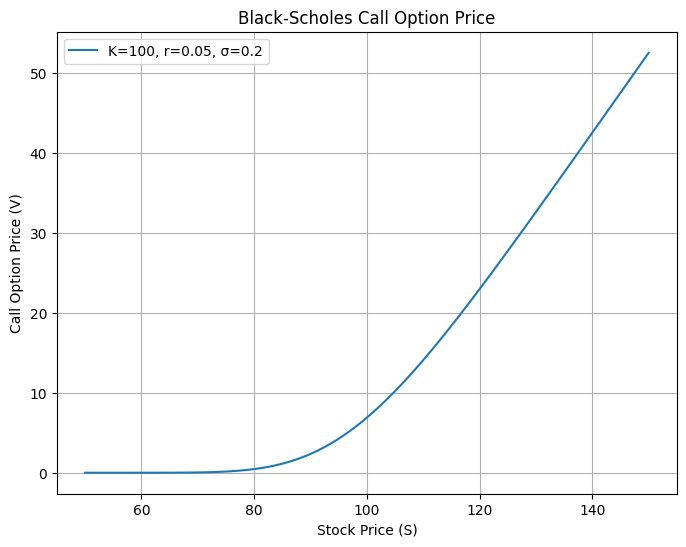

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula for a European Call Option
def black_scholes_call(S, K, T, r, sigma):
    """
    S: Stock price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free interest rate
    sigma: Volatility of the underlying asset
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Parameters
K = 100        # Strike price
r = 0.05       # Risk-free rate (5%)
sigma = 0.2    # Volatility (20%)
T = 0.5        # Time to maturity (default: 6 months)

# Function to plot 2D graph with selectable x-axis
def plot_black_scholes_2d(x_axis='stock_price', S_range=(50, 150), T_range=(0.01, 1), num_points=100):
    if x_axis == 'stock_price':
        # X-axis: Stock price, Y-axis: Option price
        S = np.linspace(S_range[0], S_range[1], num_points)
        V = black_scholes_call(S, K, T, r, sigma)
        print(V)
        x_data = S
        y_data = V
        x_label = 'Stock Price (S)'
        y_label = 'Call Option Price (V)'
    
    elif x_axis == 'time':
        # X-axis: Time to maturity, Y-axis: Option price
        T_values = np.linspace(T_range[0], T_range[1], num_points)
        S_fixed = 100  # Fixed stock price (e.g., at-the-money)
        V = black_scholes_call(S_fixed, K, T_values, r, sigma)
        x_data = T_values
        y_data = V
        x_label = 'Time to Maturity (T)'
        y_label = 'Call Option Price (V)'
    
    else:
        raise ValueError("x_axis must be 'stock_price' or 'time'")

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(x_data, y_data, label=f'K={K}, r={r}, σ={sigma}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Black-Scholes Call Option Price')
    plt.grid(True)
    plt.legend()
    plt.show()

# Default: Stock price (S) vs Option price (V)
plot_black_scholes_2d(x_axis='stock_price')

# Example: Time (T) vs Option price (V)
# Uncomment the line below to try it
# plot_black_scholes_2d(x_axis='time')